# **Set up your TPU environment**



In [4]:
import os, sys, json
import tensorflow as tf
import tensorflow_gcs_config

# # set up TPU strategy
# assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
# TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
!pip install -q tf-models-official==2.3.0
# !pip install -q tensorflow==2.3.0
# !pip install -q tf-models-nightly
# !pip install -q tf-nightly

In [6]:
from google.colab import files
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Load Data**

The Amazon Fine Food Reviews dataset is downloaded from https://www.kaggle.com/snap/amazon-fine-food-reviews. 

In [7]:
# upload kaggle.json file
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"tianyushi94","key":"4492463f9aa5b5f09c0e366bf17c6287"}'}

In [8]:
!pip install kaggle

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d snap/amazon-fine-food-reviews

kaggle.json
 95% 231M/242M [00:04<00:00, 91.7MB/s]
100% 242M/242M [00:04<00:00, 56.7MB/s]


In [10]:
!unzip -q amazon-fine-food-reviews.zip -d .

replace ./Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [11]:
!rm amazon-fine-food-reviews.zip
!rm database.sqlite
!rm hashes.txt

In [12]:
# Load csv files
df = pd.read_csv('Reviews.csv')

In [13]:
# Shuffle the dataset
np.random.seed(2020)
df = df.reindex(np.random.permutation(df.index))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
471635,471636,B000CSBVOO,A2TYOJB7EKHLMJ,"Robert Solomon ""drrob1""",0,0,5,1310774400,This is what I was looking for,"My cafeteria sometimes has Smart Start, and so..."
56346,56347,B007HOWZJQ,AZU9FXAINRFT2,LBOK,4,4,5,1339977600,Great sugar substitute!,This product is great. It tastes just like sug...
424181,424182,B000MGOZEO,A1SQ7NX5805BXU,Charles White,16,16,4,1222819200,"Most of the sweet, none of the yuk",I can taste artificial sweeteners from across ...
460337,460338,B00507A02Q,A3Q2TRYNMSXHV5,Disappointed,21,23,1,1338249600,Throwing up,This is DISGUSTING! I wish i could get my mone...
483020,483021,B002L8XKZG,A3BSKE30VFG3FG,ChowDownBrownCow,0,0,5,1340928000,Dakine of dakine cookies!,"The Key Lime Shortbread Cookies are divine, ab..."


# **Data pre-processing**

In [14]:
# Check the size of the dataset
df.shape

(568454, 10)

In [15]:
# Check missing values
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Clean the data by dropping the NA values

In [16]:
# Drop NA
df = df.dropna()

Text(0, 0.5, 'Counts')

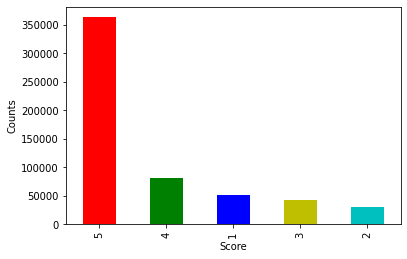

In [14]:
ax = df.Score.value_counts().plot(kind='bar',color=['r','g','b','y','c'])
ax.set_xlabel('Score')
ax.set_ylabel('Counts')

Notice that the distribution of the score is skewed towards '5', which leads to unbalanced categories. We decide to divide the score into 3 classes where '4' and '5' are positive (labeled as 2), '3' is neural (labeled as 1), and '1' and '2' are negative (labeled as 0).

In [17]:
df.Score[df.Score<=2]=0
df.Score[df.Score==3]=1
df.Score[df.Score>=4]=2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Counts')

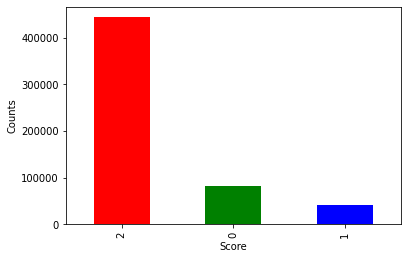

In [ ]:
ax=df.Score.value_counts().plot(kind='bar',color=['r','g','b'])
ax.set_xlabel('Score')
ax.set_ylabel('Counts')

# **K-means Clustering**

Reference: https://towardsdatascience.com/k-means-clustering-8e1e64c1561c#:~:text=Making%20Sense%20of%20Text%20Data%20using%20Unsupervised%20Learning&text=So%20what%20exactly%20is%20K,data%20points%20within%20your%20data.

## **Text and Summary**

In [28]:
data = df['Text'] + df['Summary']

In [29]:
# remove punctuation
import unicodedata
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))
def remove_punctuation(text):
    return text.translate(tbl)
data=data.apply( lambda x: remove_punctuation(x))

In [30]:
# remove html tags
import bs4
data = data.apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())

In [31]:
# Term Frequency-Inverse Document Frequency (TF-IDF)
tf_idf_vectorizor = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 3), 
                             stop_words='english')
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [32]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,add,amazon,bad,bag,best,better,bit,bought,box,brand,buy,chocolate,coffee,cup,day,delicious,did,didnt,different,does,doesnt,dog,dont,drink,easy,eat,favorite,flavor,flavors,food,free,good,got,great,healthy,im,ive,just,know,like,little,lot,love,loves,make,makes,mix,need,nice,order,ordered,perfect,price,product,quality,really,recommend,right,say,small,snack,store,stuff,sugar,sure,sweet,taste,tastes,tea,think,time,tried,try,use,used,want,water,way,years
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.753504,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.657443,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.242684,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.329289,0.0,0.000000,0.0,0.169033,0.0,0.149080,0.0,0.267108,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.18118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.518478,0.274245,0.00000,0.170702,0.496619,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.240632,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.136338,0.0,0.0,0.158793,0.680998,0.0,0.0,0.0,0.138395,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.174965,0.0,0.0,0.16896,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.10182,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.17966,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343599,0.339252,0.179445,0.16432,0.111694,0.162474,0.0,0.0,0.141352,0.0,0.000000,0.142385,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.315164,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.334577,0.0,0.0,0.00000,0.318088,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.184839,0.0,0.000000,0.0,0.0,0.275917,0.0,0.0,0.00000,0.0,0.0,0.0,0.673699,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.211648,0.000000,0.0,0.0,0.000000,0.0,0.280337,0.000000,0.000000,0.0,0.0,0.0,0.0


In [33]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

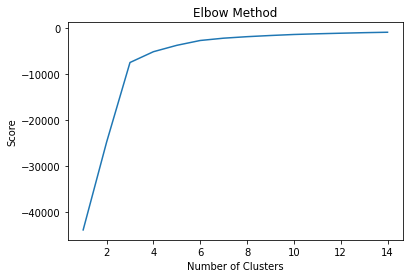

In [34]:
# Elbow plot to find the optimal number of clusters
number_clusters = range(1, 15)
kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

According to the elbow plot, we will go with 3 clusters.

In [35]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

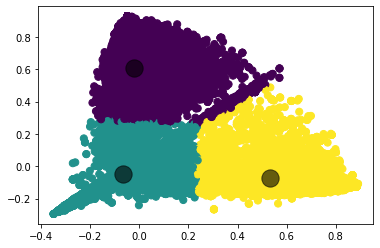

In [36]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [37]:
# Examining the Top words in each Cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

In [38]:
dfs_5 = get_top_features_cluster(tf_idf_array, prediction, 5)
dfs_15 = get_top_features_cluster(tf_idf_array, prediction, 15)
dfs_30 = get_top_features_cluster(tf_idf_array, prediction, 30)
dfs_45 = get_top_features_cluster(tf_idf_array, prediction, 45)

Show the top N words in each cluster. For example 15.

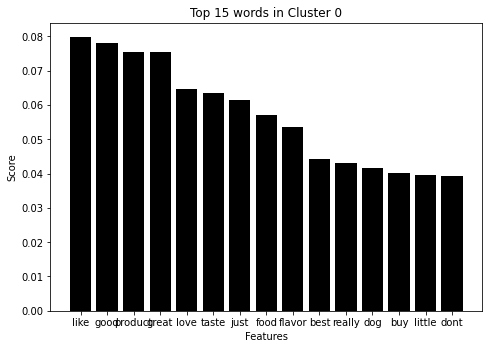

In [45]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = dfs_15[0]['features']
score = dfs_15[0]['score']
ax.bar(features,score,color='k')
ax.set_xlabel('Features')
ax.set_ylabel('Score')
ax.set_title('Top 15 words in Cluster 0')
plt.show()

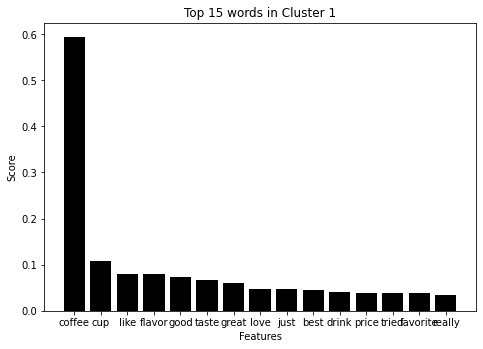

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = dfs_15[1]['features']
score = dfs_15[1]['score']
ax.bar(features,score,color='k')
ax.set_xlabel('Features')
ax.set_ylabel('Score')
ax.set_title('Top 15 words in Cluster 1')
plt.show()

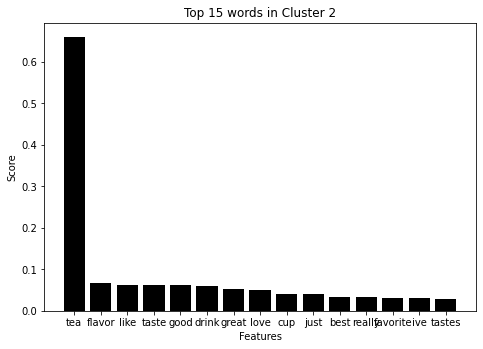

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = dfs_15[2]['features']
score = dfs_15[2]['score']
ax.bar(features,score,color='k')
ax.set_xlabel('Features')
ax.set_ylabel('Score')
ax.set_title('Top 15 words in Cluster 2')
plt.show()

It seems like Cluster 1 is focused on the topic of tea and Cluster 2 puts most of its attention to coffee. There is no dominant word in Cluster 0, and Cluster 0 is probably composed of other food.

In [77]:
df0 = pd.concat(dfs_5,ignore_index=True)
df0.sort_values("score", ascending=False, inplace = True) 
X_top_5 = df0.drop_duplicates(['features'],keep= 'first').nlargest(5,'score').reset_index()['features']
X_top_5

0       tea
1    coffee
2       cup
3      like
4    flavor
Name: features, dtype: object

In [27]:
df1 = pd.concat(dfs_15,ignore_index=True)
df1.sort_values("score", ascending=False, inplace = True) 
X_top_15 = df1.drop_duplicates(['features'],keep= 'first').nlargest(15,'score').reset_index()['features']
X_top_15

0         tea
1      coffee
2         cup
3        like
4      flavor
5        good
6     product
7       great
8       taste
9        love
10       just
11      drink
12       food
13       best
14     really
Name: features, dtype: object

In [28]:
df2 = pd.concat(dfs_30,ignore_index=True)
df2.sort_values("score", ascending=False, inplace = True) 
X_top_30 = df2.drop_duplicates(['features'],keep= 'first').nlargest(30,'score').reset_index()['features']
X_top_30

0           tea
1        coffee
2           cup
3          like
4        flavor
5          good
6       product
7         great
8         taste
9          love
10         just
11        drink
12         food
13         best
14       really
15          dog
16          buy
17       little
18         dont
19        price
20        tried
21          eat
22          use
23     favorite
24         time
25       amazon
26       better
27    chocolate
28        loves
29         make
Name: features, dtype: object

In [29]:
df3 = pd.concat(dfs_45,ignore_index=True)
df3.sort_values("score", ascending=False, inplace = True) 
X_top_45 = df3.drop_duplicates(['features'],keep= 'first').nlargest(45,'score').reset_index()['features']
X_top_45

0           tea
1        coffee
2           cup
3          like
4        flavor
5          good
6       product
7         great
8         taste
9          love
10         just
11        drink
12         food
13         best
14       really
15          dog
16          buy
17       little
18         dont
19        price
20        tried
21          eat
22          use
23     favorite
24         time
25       amazon
26       better
27    chocolate
28        loves
29         make
30          ive
31           im
32       tastes
33          try
34       bought
35         used
36        sweet
37          bag
38    delicious
39         nice
40        snack
41        order
42          day
43        water
44        sugar
Name: features, dtype: object

# **BERT model (Score Prediction)**

Reference:
https://www.tensorflow.org/official_models/fine_tuning_bert

We want to build a model that predicts score based on summary and text.

## **Data for BERT**

In [30]:
X_s = df['Summary']
X_t = df['Text']
y = df['Score']

In [31]:
# Encode class values as integers
label_encoder = LabelEncoder().fit(df['Score'])
y_train_val = label_encoder.fit_transform(df['Score'])

Split the data into training, validation, and test sets.

In [32]:
X_s_train_val, X_s_test, X_t_train_val, X_t_test, y_train_val, y_test = train_test_split(
        X_s, X_t, y, test_size=0.2, random_state=0, stratify = y_train_val
        )

In [33]:
X_s_train, X_s_val, X_t_train, X_t_val, y_train, y_val = train_test_split(
        X_s_train_val, X_t_train_val, y_train_val, test_size=0.2, random_state=0, stratify = y_train_val
        )

## **The BERT tokenizer**

In [34]:
# This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this notebook
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [35]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [36]:
def encode_sentence(s,tokenizer,max_seq_len):
  tokens = tokenizer.tokenize(s)
  tokens = tokens[:max_seq_len]
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

In [37]:
def bert_encode(X_s, X_t, tokenizer,max_seq_len):
  num_examples = len(X_s)
  
  summary = tf.ragged.constant([
      encode_sentence(s, tokenizer,max_seq_len)
      for s in np.array(X_s)])
  
  text = tf.ragged.constant([
      encode_sentence(s, tokenizer,max_seq_len)
       for s in np.array(X_t)])
  
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*summary.shape[0]

  input_word_ids = tf.concat([cls, summary, text], axis=-1)
  input_mask = tf.ones_like(input_word_ids).to_tensor()
  type_cls = tf.zeros_like(cls)
  type_summary = tf.zeros_like(summary)
  type_text = tf.ones_like(text)
  input_type_ids = tf.concat(
      [type_cls, type_summary, type_text], axis=-1).to_tensor()
  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
# The maximum embedding length of BERT is 512, so we need to truncate the input sequence using the parameter "max_seq_len"
X_train = bert_encode(X_s_train, X_t_train, tokenizer,400)
X_val = bert_encode(X_s_val, X_t_val, tokenizer,400)
X_test = bert_encode(X_s_test, X_t_test, tokenizer,400)

In [ ]:
# Check the size of X tensors
for key, value in X_train.items():
  print(f'{key:15s} shape: {value.shape}')
for key, value in X_val.items():
  print(f'{key:15s} shape: {value.shape}')
for key, value in X_test.items():
  print(f'{key:15s} shape: {value.shape}')
print(f'train_labels shape: {y_train.shape}')

input_word_ids  shape: (363782, 490)
input_mask      shape: (363782, 490)
input_type_ids  shape: (363782, 490)
input_word_ids  shape: (90946, 468)
input_mask      shape: (90946, 468)
input_type_ids  shape: (90946, 468)
input_word_ids  shape: (113683, 463)
input_mask      shape: (113683, 463)
input_type_ids  shape: (113683, 463)
train_labels shape: (363782,)


In [ ]:
# padding with zeros
d1 = 512 - X_train['input_mask'].shape[1]
d2 = 512 - X_val['input_mask'].shape[1]
d3 = 512 - X_test['input_mask'].shape[1]

X_train_tokens = X_train
X_val_tokens = X_val
X_test_tokens = X_test

paddings_1 = tf.constant([[0, 0,], [0, d1]])
X_train_tokens['input_mask'] = tf.pad(X_train_tokens['input_mask'], paddings_1, "CONSTANT")
X_train_tokens['input_type_ids'] = tf.pad(X_train_tokens['input_type_ids'], paddings_1, "CONSTANT")
X_train_tokens['input_word_ids'] = tf.pad(X_train_tokens['input_word_ids'], paddings_1, "CONSTANT")


paddings_2 = tf.constant([[0, 0,], [0, d2]])
X_val_tokens['input_mask'] = tf.pad(X_val_tokens['input_mask'], paddings_2, "CONSTANT")
X_val_tokens['input_type_ids'] = tf.pad(X_val_tokens['input_type_ids'], paddings_2, "CONSTANT")
X_val_tokens['input_word_ids'] = tf.pad(X_val_tokens['input_word_ids'], paddings_2, "CONSTANT")

paddings_3 = tf.constant([[0, 0,], [0, d3]])
X_test_tokens['input_mask'] = tf.pad(X_test_tokens['input_mask'], paddings_3, "CONSTANT")
X_test_tokens['input_type_ids'] = tf.pad(X_test_tokens['input_type_ids'], paddings_3, "CONSTANT")
X_test_tokens['input_word_ids'] = tf.pad(X_test_tokens['input_word_ids'], paddings_3, "CONSTANT")

In [ ]:
# Check the size of X tensors
for key, value in X_train_tokens.items():
  print(f'{key:15s} shape: {value.shape}')
for key, value in X_val_tokens.items():
  print(f'{key:15s} shape: {value.shape}')
for key, value in X_test_tokens.items():
  print(f'{key:15s} shape: {value.shape}')
print(f'train_labels shape: {y_train.shape}')

input_word_ids  shape: (363782, 512)
input_mask      shape: (363782, 512)
input_type_ids  shape: (363782, 512)
input_word_ids  shape: (90946, 512)
input_mask      shape: (90946, 512)
input_type_ids  shape: (90946, 512)
input_word_ids  shape: (113683, 512)
input_mask      shape: (113683, 512)
input_type_ids  shape: (113683, 512)
train_labels shape: (363782,)


## **Build the model**

In [ ]:
# Download the configuration for the pre-trained model.
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
with tpu_strategy.scope():
    bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=3,max_seq_length=None)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_mask:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_mask:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_type_ids:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_type_ids:0


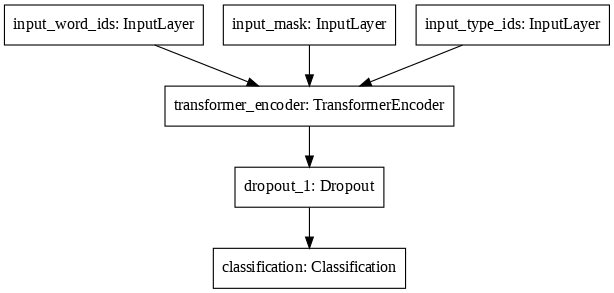

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=False, dpi=80)

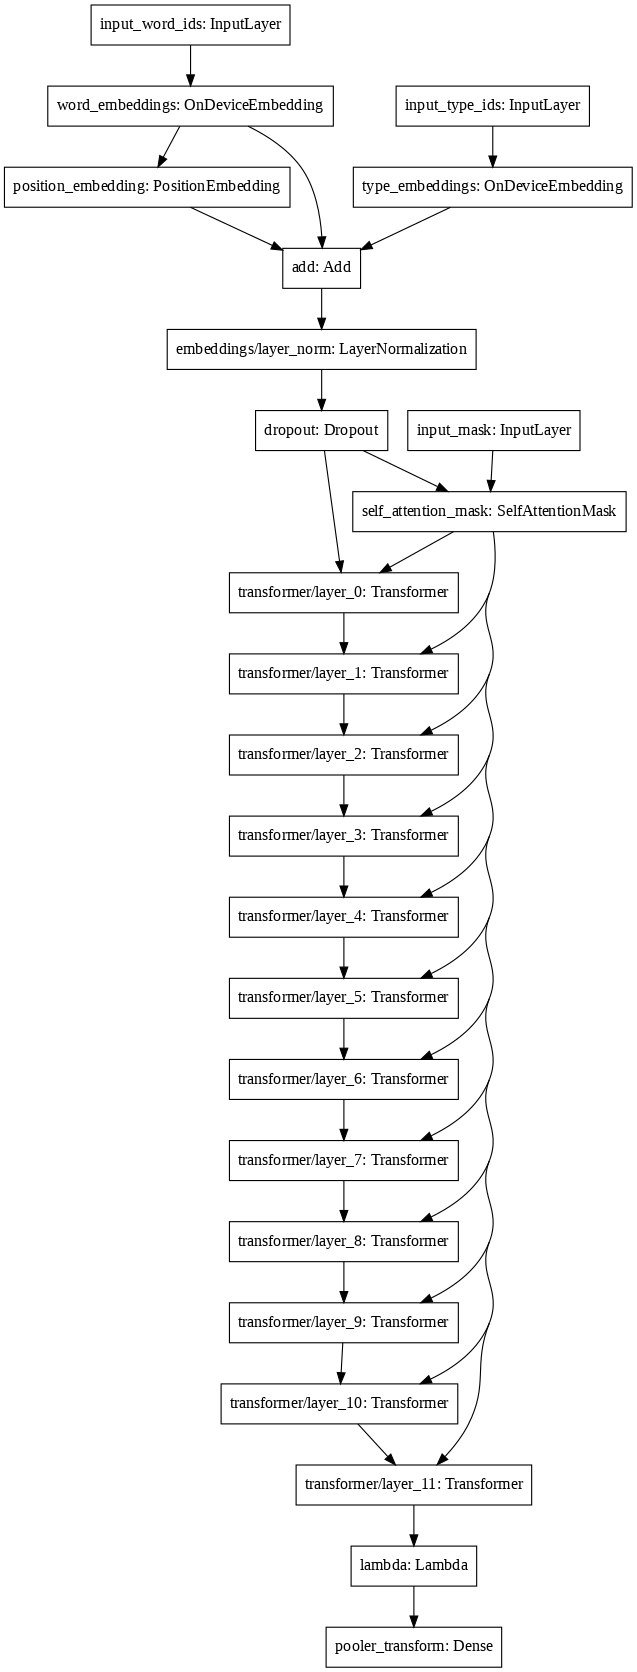

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=False, dpi=80)

In [ ]:
bert_classifier.summary()

Model: "bert_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme [(None, None, 768),  109482240   input_word_ids[0][0]             
                                                                 input_mask[0][0]   

## **Train the model**

In [ ]:
# Restore the encoder's weights from the checkpoint
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Set up epochs and steps
# epoch = 2,3
# batch_size = 32, 64
# learning rate = 2e-5 to 1e-4

epochs = 2
batch_size = 64
eval_batch_size = 64

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    8e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
with tpu_strategy.scope():
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  bert_classifier.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

with tpu_strategy.scope():
  history = bert_classifier.fit(
      X_train_tokens, y_train,
      validation_data=(X_val_tokens, y_val),
      batch_size=64,
      epochs=epochs)

Epoch 1/2
5685/5685 [==============================] - 1500s 264ms/step - loss: 0.2280 - accuracy: 0.9110 - val_loss: 0.1785 - val_accuracy: 0.9347
Epoch 2/2
5685/5685 [==============================] - 1468s 258ms/step - loss: 0.1285 - accuracy: 0.9536 - val_loss: 0.1496 - val_accuracy: 0.9469


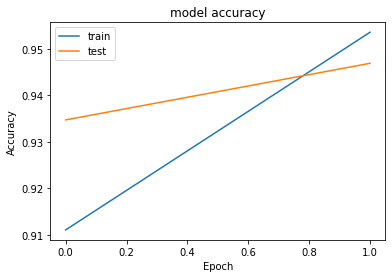

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

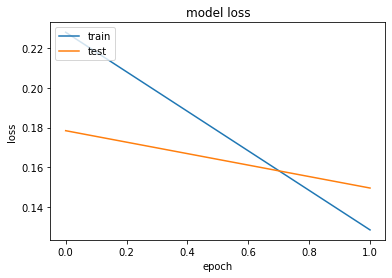

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Prediction**

In [ ]:
preds = bert_classifier.predict(X_test_tokens)

In [ ]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(
    y_test, preds, sample_weight=None
)
print("Accuracy:{}".format(m.result().numpy()))

Accuracy:0.9457966685295105


In [75]:
outputs = [np.argmax(p, axis = -1) for p in preds]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, outputs)

array([[14826,  1110,   465],
       [ 1404,  5510,  1614],
       [  457,  1112, 87185]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, outputs)

0.9457966450568687

# **BERT model with additional features**

In [79]:
# Create a copy of the tokenizer
import copy
tokenizer0 = copy.deepcopy(tokenizer)
tokenizer1 = copy.deepcopy(tokenizer)
tokenizer2 = copy.deepcopy(tokenizer)
tokenizer3 = copy.deepcopy(tokenizer)

In [39]:
# Modify the vacabulary of BERT by replacing the unused tokens with the top 15 words obtained from K-Means Clustering
# Here the keys '[unused0]','[unused1]',......,'[unused14]' are replaced
for i in range(15):
  tokenizer1.vocab[X_top_15[i]] = tokenizer1.vocab.pop('[unused'+str(i)+']')

In [80]:
for i in range(5):
  tokenizer0.vocab[X_top_5[i]] = tokenizer0.vocab.pop('[unused'+str(i)+']')

In [40]:
for i in range(30):
  tokenizer2.vocab[X_top_30[i]] = tokenizer2.vocab.pop('[unused'+str(i)+']')

In [74]:
for i in range(45):
  tokenizer3.vocab[X_top_45[i]] = tokenizer3.vocab.pop('[unused'+str(i)+']')

In [81]:
# Tokenize with the new tokenizer
X_train = bert_encode(X_s_train, X_t_train, tokenizer0,400)
X_val = bert_encode(X_s_val, X_t_val, tokenizer0,400)
X_test = bert_encode(X_s_test, X_t_test, tokenizer0,400)

In [82]:
# padding with zeros
d1 = 512 - X_train['input_mask'].shape[1]
d2 = 512 - X_val['input_mask'].shape[1]
d3 = 512 - X_test['input_mask'].shape[1]

X_train_tokens = X_train
X_val_tokens = X_val
X_test_tokens = X_test

paddings_1 = tf.constant([[0, 0,], [0, d1]])
X_train_tokens['input_mask'] = tf.pad(X_train_tokens['input_mask'], paddings_1, "CONSTANT")
X_train_tokens['input_type_ids'] = tf.pad(X_train_tokens['input_type_ids'], paddings_1, "CONSTANT")
X_train_tokens['input_word_ids'] = tf.pad(X_train_tokens['input_word_ids'], paddings_1, "CONSTANT")


paddings_2 = tf.constant([[0, 0,], [0, d2]])
X_val_tokens['input_mask'] = tf.pad(X_val_tokens['input_mask'], paddings_2, "CONSTANT")
X_val_tokens['input_type_ids'] = tf.pad(X_val_tokens['input_type_ids'], paddings_2, "CONSTANT")
X_val_tokens['input_word_ids'] = tf.pad(X_val_tokens['input_word_ids'], paddings_2, "CONSTANT")

paddings_3 = tf.constant([[0, 0,], [0, d3]])
X_test_tokens['input_mask'] = tf.pad(X_test_tokens['input_mask'], paddings_3, "CONSTANT")
X_test_tokens['input_type_ids'] = tf.pad(X_test_tokens['input_type_ids'], paddings_3, "CONSTANT")
X_test_tokens['input_word_ids'] = tf.pad(X_test_tokens['input_word_ids'], paddings_3, "CONSTANT")

## **Build the model**

In [46]:
# Download the configuration for the pre-trained model.
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [47]:
with tpu_strategy.scope():
    bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=3,max_seq_length=None)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_mask_1:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_mask_1:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_type_ids_1:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_type_ids_1:0


## **Train the model**

In [83]:
# Restore the encoder's weights from the checkpoint
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [84]:
# Set up epochs and steps
# epoch = 2,3
# batch_size = 32, 64
# learning rate = 2e-5 to 1e-4

epochs = 2
batch_size = 64
eval_batch_size = 64

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    8e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [85]:
with tpu_strategy.scope():
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  bert_classifier.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

with tpu_strategy.scope():
  history = bert_classifier.fit(
      X_train_tokens, y_train,
      validation_data=(X_val_tokens, y_val),
      batch_size=64,
      epochs=epochs)

Epoch 1/2
5685/5685 [==============================] - 1526s 268ms/step - accuracy: 0.9146 - loss: 0.2231 - val_accuracy: 0.9368 - val_loss: 0.1673
Epoch 2/2
5685/5685 [==============================] - 1492s 262ms/step - accuracy: 0.9531 - loss: 0.1279 - val_accuracy: 0.9472 - val_loss: 0.1490


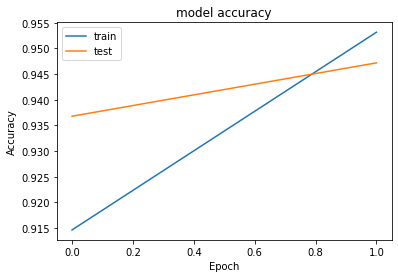

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

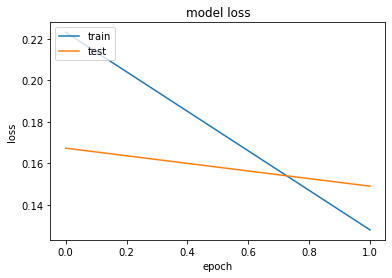

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Prediction**

In [88]:
preds = bert_classifier.predict(X_test_tokens)

In [89]:
y_test.replace('positive',0,True)
y_test.replace('negative',1,True)
y_test.replace('neutral',2,True)

In [90]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(
    y_test, preds, sample_weight=None
)
print("Accuracy:{}".format(m.result().numpy()))

Accuracy:0.9459813833236694


In [91]:
outputs = [np.argmax(p, axis = -1) for p in preds]

In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, outputs)

array([[14858,  1107,   436],
       [ 1402,  5637,  1489],
       [  482,  1225, 87047]])

In [71]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, outputs)

0.9453480291688291